In [36]:

# Importing Relevant Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from category_encoders import CountEncoder

import xgboost     # extreme gradient boosting

# To visualize the 100 many the columns in data
pd.options.display.max_columns=100


In [111]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_tr)
        test_out = estimator.decision_function(X_te)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_tr)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_te)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    cm_display = ConfusionMatrixDisplay.from_estimator(estimator, X_te, y_te, cmap="plasma", normalize='true')
    cm_display.plot(cmap="plasma")
   

In [9]:
data1 = pd.read_csv('training_set_features.csv')
data1.head()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [85]:
# Reading in the target data
data2 = pd.read_csv('training_set_labels.csv')
data2.head()

,respondent_id,xyz_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [86]:
# Exploring the percentage breakdown of the two classes in one possible target (seasonal flu rate)
data2['seasonal_vaccine'].value_counts(normalize=True) 

seasonal_vaccine
0    0.534392
1    0.465608
Name: proportion, dtype: float64

In [87]:
data2['xyz_vaccine'].value_counts(normalize=True)

xyz_vaccine
0    0.787546
1    0.212454
Name: proportion, dtype: float64

In [88]:
df = data1.merge(data2, how='left', on='respondent_id')
df.head()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [89]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   xyz_concern                  26615 non-null  float64
 2   xyz_knowledge                26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_xyz              24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [90]:
df.isna().sum()

respondent_id                      0
xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [91]:
df.describe()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,xyz_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


In [92]:
# Explore object columns
df[[c for c in df.columns if df[c].dtype =='object']].describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


In [148]:
# Define our X and y
X = df.drop(columns = ['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'], axis=1)
y = df['xyz_vaccine']                                          # change xyz_vaccine to seasonal_vaccine and
# run all following columns again to get seasonal probablity and in 1 turn don't run last cell


In [149]:
# Train - Holdout Set Split
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [150]:
# Regular Train Test Split
X, X_te, y, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [151]:
num_cols = []
ohe_cols = []
freq_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [152]:
# We wanted to see each column category
print(f'Numerical Columns:', num_cols)
print('\n')
print(f'Object Columns (with less than 10 unique values):', ohe_cols)
print('\n')
print(f'Object Columns (with more than 10 unique values):', freq_cols)

Numerical Columns: ['xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk', 'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']


Object Columns (with less than 10 unique values): ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa']


Object Columns (with more than 10 unique values): ['hhs_geo_region', 'employment_industry', 'employment_occupation']


In [153]:
# Preprocessing with Pipelines
num_transformer = Pipeline(steps=[
    ('num_imputer', IterativeImputer(max_iter=100, random_state=42)),   # replace missing values by IterativeImputer
    ('minmaxscaler', MinMaxScaler())                                    # Scale the numbers by MinMaxScaler
])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # replace missing categories by SimpleImputer
    ('ohe_encoder', OneHotEncoder(handle_unknown='ignore'))                     # Transform each category into a new column
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)), # replace category names with frequency counts by CountEncoder
    ('freq_imputer', IterativeImputer(max_iter=100, random_state=42))            # replace missing values by IterativeImputer
])

In [154]:
# Preprocessor defined using ColumnTransformer by packaging the all components together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [155]:
# Fitting preprocessor to see the components as a whole
preprocessor.fit(X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['xyz_concern', 'xyz_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_t...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'census_msa']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42))]),
                                 ['hhs_geo_region', 'employment_industry',
                                  'employment_occupation'])])

In [156]:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['xyz_concern', 'xyz_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home', 'behavioral_touch_face', 
                                  'doctor_recc_xyz', 'doctor_recc_seasonal', 'chronic_med_condition', 
                                  'child_under_6_months', 'health_worker', 'health_insurance'],
                                  
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'census_msa']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42))]),
                                 ['hhs_geo_region', 'employment_industry',
                                  'employment_occupation'])])

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['xyz_concern', 'xyz_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_t...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'census_msa']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42))]),
                                 ['hhs_geo_region', 'employment_industry',
                                  'employment_occupation'])])

In [157]:
X_tr_transformed = preprocessor.transform(X)
X_tr_transformed.shape

(19228, 59)

In [158]:
# Visualize it with Pandas dataframe 
pd.DataFrame(X_tr_transformed).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,1.000000,0.5,0.016076,0.963804,0.038064,0.894508,0.0,1.000000,0.0,0.116478,0.141558,1.0,0.0,1.000000,0.779010,0.75,0.296807,0.75,0.75,0.279800,0.75,0.333333,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.106407,0.499168,0.504213
1,0.666667,1.0,0.016076,0.000000,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,0.0,0.110629,0.920662,0.75,0.765602,0.25,0.75,0.759933,0.25,0.333333,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.160235,0.340961,0.371854
2,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,0.0,1.000000,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.00,1.00,0.279800,0.00,0.333333,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.076659,0.499168,0.504213
3,0.333333,0.5,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,1.000000,0.0,0.0,0.110629,0.920662,0.75,0.296807,0.25,0.75,0.279800,0.25,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.499168,0.504213
4,0.333333,1.0,0.016076,0.963804,0.038064,0.894508,0.0,0.013143,1.0,0.116478,0.141558,0.0,1.0,1.000000,0.920662,0.25,0.062409,0.00,0.75,0.279800,0.25,0.666667,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160235,0.340961,0.371854


Training Scores:
Train Accuracy: 0.895933014354067
Train Precision: 0.8400783289817232
Train Recall: 0.630110159118727
Train F1-Score: 0.7201007133864876
**********
Testing Scores:
Test Accuracy: 0.8548252911813644
Test Precision: 0.720108695652174
Test Recall: 0.5185909980430529
Test F1-Score: 0.602957906712173


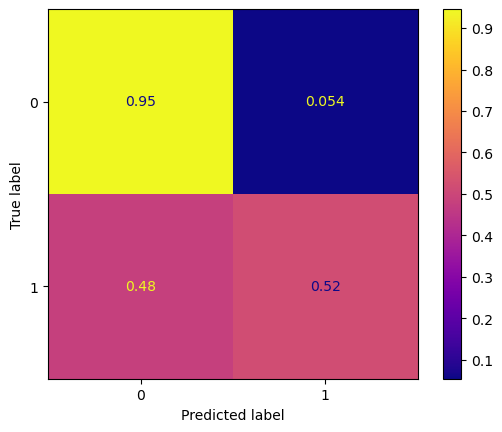

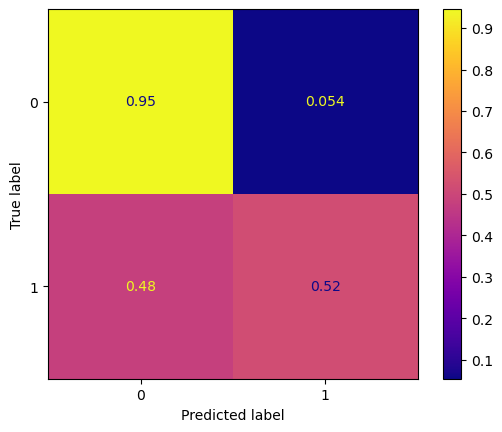

In [159]:
# Setting up the gradient boosting classifier to go through the pipeline
gbc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 200,
        random_state=42))
])

# The parameters are chosen based on GridSearchCV done in Project3_model_iterations.ipynb notebook results!
# Fitting the gradient boosting classifier to the training data
gbc.fit(X, y)
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['xyz_concern', 'xyz_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home', 'behavioral_touch_face', 
                                  'doctor_recc_xyz', 'doctor_recc_seasonal', 'chronic_med_condition', 
                                  'child_under_6_months', 'health_worker', 'health_insurance']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=200,
                                            random_state=42))])
# Evaluate the gradient boosting model for various metrics

evaluate(gbc, X, X_te, y, y_te)

In [161]:
new_data_file = 'test_set_features.csv'  # Update with your actual file name
new_data = pd.read_csv(new_data_file)

# Step 2: Make predictions using the trained model
predictions = gbc.predict(new_data)

# If you want to include the probabilities of the predictions (e.g., for classification)
probabilities = gbc.predict_proba(new_data)[:, 1]  # Probability of the positive class

# Step 3: Save the predictions to a new CSV file
new_data['Predictions'] = predictions
new_data['Prediction_Probabilities_xyz'] = probabilities  # Optional: if you included probabilities



# Optional: Save to Excel
new_data.to_excel('predicted_results.xlsx', index=False)     #change the name to predicted_results1.xlsx in second turn

print("Predictions saved to predicted_results.csv and predicted_results.xlsx")

Predictions saved to predicted_results.csv and predicted_results.xlsx


In [166]:
import pandas as pd

# Load the first Excel file
a1 = pd.read_excel('predicted_results.xlsx')

# Load the second Excel file
a2 = pd.read_excel('predicted_results1.xlsx')

# Merge the dataframes on 'respondent_id'
merged_data = pd.merge(a1, a2, on='respondent_id')

# Extract the desired columns
extracted_columns = merged_data[['respondent_id','Prediction_Probabilities_xyz', 'Prediction_Probabilities_seasonal']]

# Save the extracted columns to a new Excel file
extracted_columns.to_excel('extracted_columns1.xlsx', index=False)

print("Extracted columns saved to extracted_columns.xlsx")